## Cost-benefit Analysis - Profit Curve

#### Uber uses sign up coupon to attract new riders

![Signup Coupon](./images/uber_20_off_first_ride_coupon.png)

#### Uber also gives coupon to retain likely churning riders

![retention Coupon](./images/uber_10_off_coupon.png)

### Q: How do we leverage our Logistic Regression model with business value?
### A: Cost-benefit Analysis

#### Confusion matrix

|               |   Actual Yes   |   Actual No    |
| ------------- |:--------------:|:--------------:|
| Predicted Yes | True positive  | False negative |
| Predicted No  | False positive | True negative  |

#### Let's define our cost-benefit matrix

|               |   Actual Yes   |   Actual No    |
| ------------- |:--------------:|:--------------:|
| Predicted Yes |    gain 10     |    lose 10     |
| Predicted No  |     lose 5     |       0        |

#### Define cost-benefit matrix based on business input


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
costbenefit =  np.array([[10, -10], [-5, 0]])

In [5]:
from sklearn.metrics import confusion_matrix

def standard_confusion_matrix(y_true, y_predict):
    """Given y and predicted y, generate standard orientation
    
    Args:
    =====
    numpy array: y_true - array of true label
    numpy array: y_predict - array of predicted label
    
    Return:
    ======:
    numpy array: confusion matrix, 2x2 numpy array
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_predict)
    return np.array([[tp, fp],[fn, tn]])

def profit_curve(cost_benefit_matrix, probabilities, y_true):
    """Given cost-benefit matrix, predicted probability, 
    and true label, calculate expected profit associated with 
    each threshold.
    
    Args:
    =====
    numpy array: cost_benefit_matrix, 2x2 array
    numpy array: probabilities - array of predicted probabilities
    numpy array: y_true - array of true label
    
    Return:
    ======:
    numpy array: threshold
    numpy array: profit
    """
    threshold = sorted(probabilities, reverse = True)
    profit = []
    for t in threshold:
        y_pred = probabilities > t
        cm = standard_confusion_matrix(y_true, y_pred)
        num = float(cm.sum().sum());
        profit.append((cm/num*costbenefit).flatten().sum())
    
    return threshold, profit

def plot_profit_model(profits, label="Logistic Regression"):
    """Plot profits against pertentage of test instance
    """
    percentages = np.linspace(0, 100, len(profits))
    plt.plot(percentages, profits, label=label)
    plt.title("Profit Curve")
    plt.xlabel("Percentage of test instances (decreasing by score)")
    plt.ylabel("Profit")
    plt.legend(loc='best')
    plt.savefig('profit_curve.png')
    plt.show()
    
def find_best_threshold(thresholds, profits):
    """Find the best threshold that gives max profit
    
    Args:
    =====
    numpy array: thresholds - array of sorted threshold
    numpy array: profits - array of profits
    
    Return:
    ======:
    float: threshold that corresponds to max profit
    float: max profit
    """
    
    max_index = np.argmax(profits)
    max_threshold = thresholds[max_index]
    max_profit = np.max(profits)
    return max_threshold, max_profit

#### Train a model

In [4]:
# Load data for modeling
df = pd.read_csv('data/cleaned_data.csv')
selected_features = [u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', u'avg_surge', 
                     u'surge_pct', u'trips_in_first_30_days', u'luxury_car_user', 
                     u'weekday_pct', u'city_Astapor', u'city_King\'s Landing',u'city_Winterfell', 
                     u'phone_Android', u'phone_iPhone', u'phone_no_phone']
target = u'churn'
X = df[selected_features].values
y = df['churn'].values
# import train test split function from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.1, fit_intercept=True)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# Make prediction on training data
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
y_train_pred = lr.predict(X_train)
print("Training score:")
print(classification_report(y_train, y_train_pred))

Training score:
             precision    recall  f1-score   support

          0       0.67      0.49      0.57     15055
          1       0.74      0.85      0.79     24945

avg / total       0.71      0.72      0.71     40000



In [10]:
# Make predictions on test data
y_test_pred = lr.predict(X_test)
print("Test score:")
print(classification_report(y_test, y_test_pred))

Test score:
             precision    recall  f1-score   support

          0       0.68      0.50      0.57      3749
          1       0.74      0.86      0.79      6251

avg / total       0.72      0.72      0.71     10000



#### Plot profit curve

In [12]:
# Make prediction on the probabilities
probabilities = lr.predict_proba(X_test)[:, 1]

# Calculate expected profits corresponding to different threshold
thresholds, profits = profit_curve(costbenefit, probabilities, y_test)

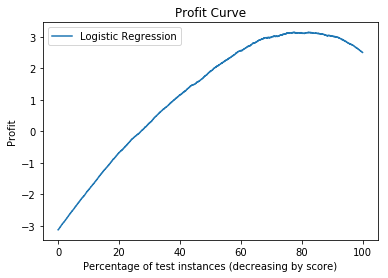

In [13]:
plot_profit_model(profits, label="Logistic Regression")

In [14]:
max_threshold, max_profit = find_best_threshold(thresholds, profits)


#### Find the best threshold


In [15]:
print("The best threshold is {}, which gives a max profit of {}".format(max_threshold, max_profit))

The best threshold is 0.4128285121335864, which gives a max profit of 3.143


#### Make predictions with chosen threshold


In [16]:
y_test_pred =  probabilities >= max_threshold
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.74      0.35      0.48      3749
          1       0.71      0.93      0.80      6251

avg / total       0.72      0.71      0.68     10000



In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

print("Area Under Curve (AUC) of the Logistic Regression is: {}".format(roc_auc_score(y_test, y_test_pred)))

Area Under Curve (AUC) of the Logistic Regression is: 0.6403463896030036
